# Visualizing Dirichelet Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
import matplotlib.colors as colors
from tqdm.notebook import tqdm 
import random
import pickle
import seaborn as sns
from pref_voting.generate_spatial_profiles import *


In [ ]:
# num_dims = 2

# num_cands_incumbent_party = 2
# num_cands_opposition_party = 2

# pr_incumbent_party_voters = 0.5
# concentration_param_for_num_voters = 100

# num_voters = 1000

# # Generate candidate clusters
# cand_clusters = [
#     ((-1, 0), generate_covariance(num_dims, 0.5, 0), num_cands_incumbent_party),  # Incumbent party
#     ((1, 0), generate_covariance(num_dims, 0.5, 0), num_cands_opposition_party),  # Opposition party
# ]

# # Generate voter clusters
# v_size_incumbent, v_size_opposition = np.random.dirichlet([
#     pr_incumbent_party_voters * concentration_param_for_num_voters, 
#     (1 - pr_incumbent_party_voters) * concentration_param_for_num_voters
# ])

# voter_clusters = [
#     ((-1, 0), generate_covariance(num_dims, 0.5, 0), int(num_voters * v_size_incumbent)),  # Incumbent voters
#     ((1, 0), generate_covariance(num_dims, 0.5, 0), int(num_voters * v_size_opposition)),  # Opposition voters
# ]

# # Generate spatial and utility profiles
# sprof = generate_spatial_profile_polarized(cand_clusters, voter_clusters, cluster_types = ["incumbent party", "opposition party"])

# sprof.view()

# prof = sprof.to_utility_profile().to_ranking_profile()
# new_prof = prof.remove_candidates([0])
# print(new_prof.plurality_scores())

# pickle.dump(sprof, open(f"spatial_prof_example_figure9.pickle", "wb" ))

In [9]:
min_num_samples_for_subjective_prob = 10 #1_000
max_num_samples_for_subjective_prob = 10 #0_000

num_cands_incumbent_party = 2
num_cands_opposition_party = 2

num_voters = 1_000
pr_incumbent_party_voters = 0.5
concentration_param_for_num_voters = 100

binom_ci_threshold_for_events = 0.01
min_num_samples_for_events = 1_000
max_num_samples_for_events = 1_000#100_000

verbose = False

sprof = pickle.load(open("spatial_prof_example_figure9.pickle", "rb"))


prof = sprof.to_utility_profile().to_ranking_profile()
new_prof = prof.remove_candidates([0])
num_voters = new_prof.num_voters
print(new_prof.plurality_scores())

plurality_scores = new_prof.plurality_scores()

print([plurality_scores[c] / num_voters for c in plurality_scores])

{1: 424, 2: 310, 3: 265}
[0.4244244244244244, 0.3103103103103103, 0.2652652652652653]


In [10]:

def largest_pl_score_event(pl_scores):

    max_pl_score = max(pl_scores)
    event = [int(score == max_pl_score) for score in pl_scores]
    return event

def top_two_pl_score_event(pl_scores): 
    sorted_pl_scores = sorted(pl_scores, reverse=True)
    event = [int(score in sorted_pl_scores[:2]) for score in pl_scores]
    return event

def find_candidate_distances(sprof): 
    dist = {c: {} for c in sprof.candidates}
    for c1 in sprof.candidates: 
        for c2 in sprof.candidates: 
            dist[c1][c2] = np.linalg.norm(sprof.candidate_position(c1) - sprof.candidate_position(c2))
    return dist

def generate_strategic_vote_shares(
        vote_shares, top_two_cands, sprof, manipulation_level): 
    """
    Return a vector of vote shares taking into account the voters that strategize
    """
    cand_distances = find_candidate_distances(sprof)
    updated_vote_shares = vote_shares.copy()

    top_two_c1, top_two_c2 = top_two_cands
    for c  in vote_shares.keys(): 
        v = vote_shares[c]
        if c in top_two_cands: 
            continue

        if cand_distances[c][top_two_c1] < cand_distances[c][top_two_c2]: 
            updated_vote_shares[top_two_c1] += manipulation_level * vote_shares[c]
            updated_vote_shares[c] -= manipulation_level * vote_shares[c]
        else: 
            updated_vote_shares[top_two_c2] += manipulation_level * vote_shares[c]
            updated_vote_shares[c] -= manipulation_level * vote_shares[c]

    return updated_vote_shares


def generate_probabilities(
    pl_scores, # dictionary of plurality scores
    num_voters, # number of voters
    concentration_param, # concentration parameter for Dirichlet distribution
    manipulation_level, # proportion of votes to transfer in strategic manipulation
    sprof,
    num_samples = 1000 # number of samples to generate from Dirichlet distribution
    ):

    """
    This function simulates a set of possible election outcomes using Dirichlet distributions over plurality scores to estimate:
      - The probability of each candidate winning the election.
      - The probability of each candidate ranking in the top two.
      - The probability of each candidate winning under strategic manipulation, where an opposition candidate is strategically weakened, and another is bolstered.

    The function returns the following dictionaries: 
        - winner_prob: Probability of each candidate winning the election.
        - top_two_prob: Probability of each candidate ranking in the top two.
        - strategic_winner_prob: Probability of each candidate winning under strategic manipulation.
    """

    candidates = sorted(list(pl_scores.keys()))
    cand_to_cidx = {c: candidates.index(c) for c in candidates}
    winner_events = [[] for c in candidates]
    top_two_events = [[] for c in candidates]

    pl_samples = np.random.dirichlet(
        [((pl_scores[c] + 1) / (num_voters + len(candidates))) * concentration_param # Laplace smoothing
        for c in candidates], 
        size = num_samples)

    for pl_sample in pl_samples:

        # check if any new_pl_scores is nan
        assert not np.isnan(pl_sample).any(), "Dirichlet sample contains nan values"
            
        new_pl_scores  = list(pl_sample)

        winner_event = largest_pl_score_event(new_pl_scores)
        top_two_event = top_two_pl_score_event(new_pl_scores)

        for cidx, _ in enumerate(candidates):
            winner_events[cidx].append(winner_event[cidx])
            top_two_events[cidx].append(top_two_event[cidx])

    winner_prob = {c: np.mean(winner_events[cidx]) 
                   for cidx, c in enumerate(candidates)}
    top_two_prob = {c: np.mean(top_two_events[cidx]) 
                    for cidx, c in enumerate(candidates)}

    sorted_top_two_probs = sorted(list(set(top_two_prob.values())), reverse=True)

    cands_with_top_prob = [c for c in candidates if top_two_prob[c] == sorted_top_two_probs[0]]

    if len(cands_with_top_prob) >= 2: 
        top_two = random.sample(cands_with_top_prob, k=2)   
    else: 
        top1 = random.choice(cands_with_top_prob) 
        top2 = random.choice([c for c in candidates if top_two_prob[c] == sorted_top_two_probs[1]]) 
        top_two = [top1, top2]

    strategic_winner_events = [[] for c in candidates]

    for pl_sample in pl_samples:
        
        pl_scores  = {c: pl_sample[cand_to_cidx[c]] for c in candidates}
        updated_pl_scores = generate_strategic_vote_shares(pl_scores, top_two, sprof, manipulation_level)
        strategic_winner_event = largest_pl_score_event([updated_pl_scores[c] for c in candidates])

        for cidx, _ in enumerate(candidates):
            strategic_winner_events[cidx].append(strategic_winner_event[cidx])

    strategic_winner_prob = {c: np.mean(strategic_winner_events[cidx]) for cidx, c in enumerate(candidates)}

    if verbose: 
        print(f"plurality score vector: {pl_scores}")
        print("\twinner_prob: ", winner_prob)
        print("\ttop_two_prob: ", top_two_prob)
        print("\tstrategic_winner_prob: ", strategic_winner_prob)
    return winner_prob, top_two_prob, strategic_winner_prob


def get_sample_prs(pl_scores, concentration_param, num_voters, num_samples): 
    samples = []
    for v in range(num_voters): 
        pr,_,_ = generate_probabilities(
            pl_scores, 
            num_voters,
            concentration_param, 
            1.0,
            sprof, 
            num_samples = num_samples)
        samples.append([pr[1], pr[2], pr[3]])
    return np.array(samples)

def get_sample_strategic_prs(pl_scores, concentration_param, num_voters, num_samples): 
    samples = []
    for v in range(num_voters): 
        _,_, pr = generate_probabilities(
            pl_scores, 
            num_voters,
            concentration_param, 
            1.0,
            sprof,
            num_samples = num_samples)
        samples.append([pr[1], pr[2], pr[3]])
    return np.array(samples)



λ = 0.1:
  Mean probabilities: [0.427, 0.326, 0.247]
  Std deviations: [0.473, 0.445, 0.411]

λ = 1:
  Mean probabilities: [0.408, 0.325, 0.267]
  Std deviations: [0.347, 0.333, 0.312]

λ = 10:
  Mean probabilities: [0.430, 0.310, 0.261]
  Std deviations: [0.146, 0.140, 0.126]

λ = 100:
  Mean probabilities: [0.423, 0.310, 0.267]
  Std deviations: [0.048, 0.045, 0.045]

λ = 1000:
  Mean probabilities: [0.425, 0.310, 0.265]
  Std deviations: [0.015, 0.014, 0.013]

λ = 10000:
  Mean probabilities: [0.424, 0.310, 0.265]
  Std deviations: [0.005, 0.005, 0.005]


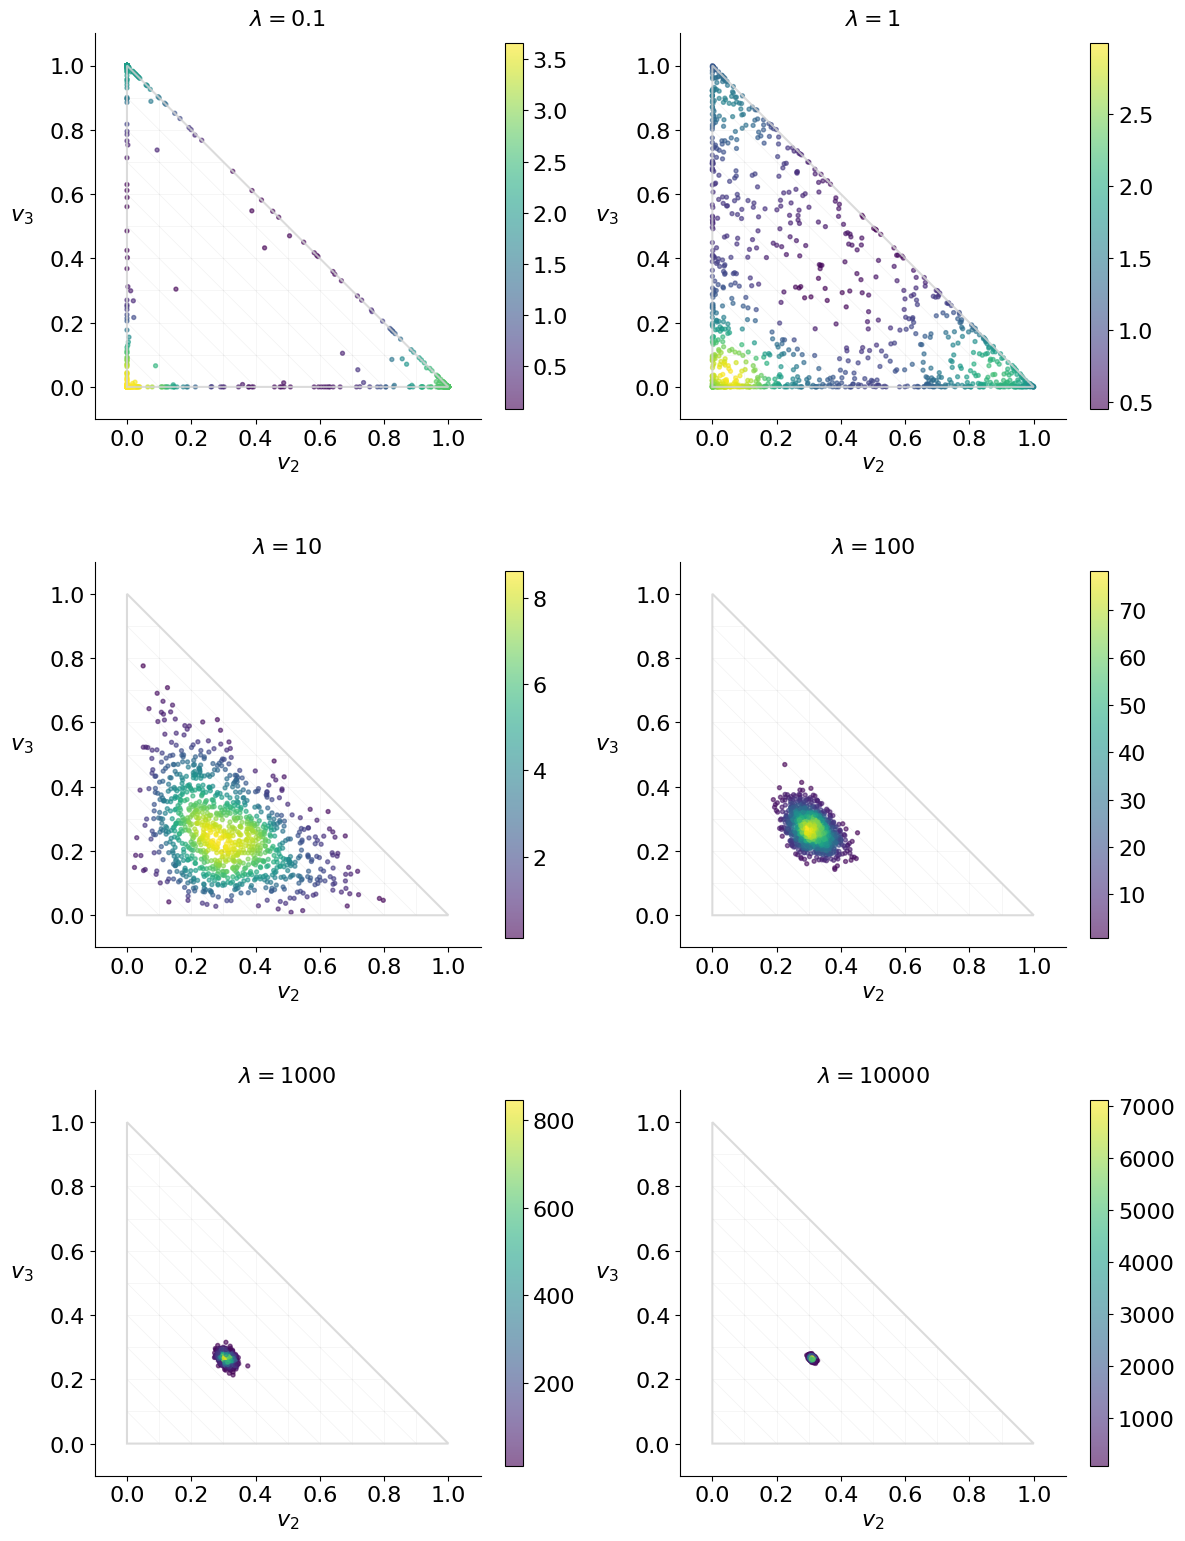

In [17]:

def plot_marshak_machina_density(lotteries, method='hexbin', figsize=(10, 8), 
                                cmap='YlOrRd', title=None, ax=None, **kwargs):
    """
    Plot density of lotteries on a Marshak-Machina right triangle.
    
    Parameters:
    -----------
    lotteries : array-like
        Array of lotteries where each row is (p1, p2, p3) with p1 + p2 + p3 = 1
    method : str
        Density visualization method: 'hexbin', 'kde', 'hist2d', 'scatter_density'
    figsize : tuple
        Figure size (width, height) - only used if ax is None
    cmap : str
        Colormap name
    title : str
        Custom title (optional)
    ax : matplotlib axis
        Existing axis to plot on (optional)
    **kwargs : additional arguments passed to plotting functions
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    fontsize=16
    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.get_figure()
    
    # Convert lotteries to numpy array and normalize
    lotteries = np.array(lotteries)
    sums = np.sum(lotteries, axis=1)
    if not np.allclose(sums, 1.0):
        print("Warning: Some lotteries don't sum to 1. Normalizing...")
        lotteries = lotteries / sums[:, np.newaxis]
    
    # Convert to (p2, p3) coordinates
    x_coords = lotteries[:, 1]  # p2
    y_coords = lotteries[:, 2]  # p3
    
    # Create triangle path for masking
    triangle_verts = [(0, 0), (1, 0), (0, 1), (0, 0)]
    triangle_path = Path(triangle_verts)
    
    # Plot density based on method
    if method == 'hexbin':
        plot_hexbin_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'kde':
        plot_kde_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'hist2d':
        plot_hist2d_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'scatter_density':
        plot_scatter_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Draw triangle outline
    if method != 'scatter_density':
        triangle = Polygon(triangle_verts[:-1], fill=False, edgecolor='black', linewidth=2, zorder=10)
        ax.add_patch(triangle)
    else:
        # For scatter density, use a light gray outline
        triangle = Polygon(triangle_verts[:-1], fill=False, edgecolor='lightgray', 
                          linewidth=1.5, alpha=0.8, zorder=2)
        ax.add_patch(triangle)
    
    # Add grid lines (lighter for scatter density)
    grid_alpha = 0.1 if method == 'scatter_density' else 0.2
    for i in range(1, 10):
        alpha = i / 10
        ax.plot([0, 1-alpha], [alpha, alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
        ax.plot([alpha, alpha], [0, 1-alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
        ax.plot([alpha, 0], [0, alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
    
    # Label vertices
    
    # Set axis properties
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xticks(np.arange(0, 1.1, 0.2))  # set xticks to 0, 0.2, 0.4, 0.6, 0.8, 1.0
    # set font size fo xticks and yticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('$v_2$', fontsize=fontsize)
    ax.set_ylabel('$v_3$', fontsize=fontsize, rotation=0, labelpad=20)    
    # Set title
    if title:
        ax.set_title(title, fontsize=fontsize)
    else:
        ax.set_title(f'Marshak-Machina Triangle - Density Plot ({method})', fontsize=14, )
    
    # Equal aspect ratio
    ax.set_aspect('equal')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig, ax

def plot_hexbin_density(ax, x, y, triangle_path, cmap, gridsize=20, mincnt=1, **kwargs):
    """Plot hexagonal binning density."""
    # Create hexbin plot
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap=cmap, mincnt=mincnt, 
                   extent=[0, 1, 0, 1], **kwargs)
    
    # Mask hexagons outside triangle
    centers = hb.get_offsets()
    inside = triangle_path.contains_points(centers)
    colors_array = hb.get_array()
    colors_array[~inside] = 0
    hb.set_array(colors_array)
    
    # Add colorbar
    cb = plt.colorbar(hb, ax=ax, label='Number of lotteries', shrink=0.8)
    return hb

def plot_kde_density(ax, x, y, triangle_path, cmap, n_grid=100, levels=10, **kwargs):
    """Plot kernel density estimation with contours."""
    # Create grid
    xi = np.linspace(-0.1, 1.1, n_grid)
    yi = np.linspace(-0.1, 1.1, n_grid)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    
    # Calculate KDE
    positions = np.vstack([xi_grid.ravel(), yi_grid.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    zi = np.reshape(kernel(positions).T, xi_grid.shape)
    
    # Mask outside triangle
    points = np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    mask = ~triangle_path.contains_points(points).reshape(xi_grid.shape)
    zi[mask] = np.nan
    
    # Plot filled contours
    cf = ax.contourf(xi_grid, yi_grid, zi, levels=levels, cmap=cmap, **kwargs)
    
    # Add contour lines
    ax.contour(xi_grid, yi_grid, zi, levels=levels, colors='black', alpha=0.3, linewidths=0.5)
    
    # Add colorbar
    cb = plt.colorbar(cf, ax=ax, label='Density', shrink=0.8)
    return cf

def plot_hist2d_density(ax, x, y, triangle_path, cmap, bins=30, **kwargs):
    """Plot 2D histogram density."""
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0, 1], [0, 1]])
    
    # Mask bins outside triangle
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    x_grid, y_grid = np.meshgrid(x_centers, y_centers)
    points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
    mask = triangle_path.contains_points(points).reshape(x_grid.shape).T
    h[~mask] = np.nan
    
    # Plot
    im = ax.imshow(h.T, origin='lower', extent=[0, 1, 0, 1], 
                   cmap=cmap, aspect='equal', **kwargs)
    
    # Add colorbar
    cb = plt.colorbar(im, ax=ax, label='Number of lotteries', shrink=0.8)
    return im

def plot_scatter_density(ax, x, y, triangle_path, cmap, alpha=0.5, s=1, **kwargs):
    """Plot scatter with density-based coloring."""
    # Calculate point density using KDE
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    density = kernel(values)
    
    # Create scatter plot
    scatter = ax.scatter(x, y, c=density, cmap=cmap, s=s, alpha=alpha, **kwargs)
    
    # Add colorbar
    cb = plt.colorbar(scatter, ax=ax, label='',  shrink=0.8)
    cb.set_label('', fontsize=16)
    cb.ax.tick_params(labelsize=16)
    return scatter

def generate_example_lotteries(n_lotteries=5000, distribution='mixed'):
    """
    Generate example lotteries with different distributions.
    
    Parameters:
    -----------
    n_lotteries : int
        Number of lotteries to generate
    distribution : str
        Type of distribution: 'uniform', 'centered', 'corners', 'mixed'
    
    Returns:
    --------
    lotteries : numpy array of shape (n_lotteries, 3)
    """
    if distribution == 'uniform':
        # Uniform distribution over the simplex
        lotteries = np.random.dirichlet([1, 1, 1], n_lotteries)
        
    elif distribution == 'centered':
        # Concentrated around center
        lotteries = np.random.dirichlet([10, 10, 10], n_lotteries)
        
    elif distribution == 'corners':
        # Concentrated near corners
        corner_probs = np.random.choice(3, n_lotteries)
        lotteries = np.zeros((n_lotteries, 3))
        for i in range(n_lotteries):
            alpha = [1, 1, 1]
            alpha[corner_probs[i]] = 20
            lotteries[i] = np.random.dirichlet(alpha)
            
    elif distribution == 'mixed':
        # Mixed distribution with clusters
        n_per_cluster = n_lotteries // 4
        
        # Cluster 1: Near (1,0,0)
        cluster1 = np.random.dirichlet([20, 1, 1], n_per_cluster)
        
        # Cluster 2: Near (0,1,0)
        cluster2 = np.random.dirichlet([1, 20, 1], n_per_cluster)
        
        # Cluster 3: Near (0,0,1)
        cluster3 = np.random.dirichlet([1, 1, 20], n_per_cluster)
        
        # Cluster 4: Near center
        cluster4 = np.random.dirichlet([5, 5, 5], n_lotteries - 3*n_per_cluster)
        
        lotteries = np.vstack([cluster1, cluster2, cluster3, cluster4])
        np.random.shuffle(lotteries)
    
    return lotteries

# Example usage
# Set random seed for reproducibility
np.random.seed(42)

# Define lambda values and base alpha
lambdas = [0.1, 1, 10, 100, 1000, 10000]
alpha_base = [plurality_scores[1] / num_voters, plurality_scores[2] / num_voters , plurality_scores[3] / num_voters]

# Create figure with 2x3 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
#fig.suptitle('Dirichlet Distribution Samples with Different λ Values', fontsize=18, y=0.98)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

# Generate and plot for each lambda
for i, (lam, ax) in enumerate(zip(lambdas, axes_flat)):
    # Scale alpha by lambda
    alpha = [a * lam for a in alpha_base]
    
    # Sample from the Dirichlet distribution
    samples = np.random.dirichlet(alpha, size=1000)
    
    # Plot on the specific axis

    
    title = f'$\\lambda = {lam}$'
    plot_marshak_machina_density(samples, method='scatter_density', 
                                title=title,
                                cmap='viridis', alpha=0.6, s=8, ax=ax)
    
    # Print summary statistics
    mean_probs = np.mean(samples, axis=0)
    std_probs = np.std(samples, axis=0)
    print(f"\nλ = {lam}:")
    print(f"  Mean probabilities: [{mean_probs[0]:.3f}, {mean_probs[1]:.3f}, {mean_probs[2]:.3f}]")
    print(f"  Std deviations: [{std_probs[0]:.3f}, {std_probs[1]:.3f}, {std_probs[2]:.3f}]")

plt.tight_layout()
plt.savefig("graphs/dirichlet_visualization.pdf")
plt.show()

## Probabilities Graphs

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
import matplotlib.colors as colors

def plot_marshak_machina_density_for_prob(lotteries, method='hexbin', figsize=(10, 8), 
                                cmap='YlOrRd', title=None, ax=None, **kwargs):
    """
    Plot density of lotteries on a Marshak-Machina right triangle.
    
    Parameters:
    -----------
    lotteries : array-like
        Array of lotteries where each row is (p1, p2, p3) with p1 + p2 + p3 = 1
    method : str
        Density visualization method: 'hexbin', 'kde', 'hist2d', 'scatter_density'
    figsize : tuple
        Figure size (width, height) - only used if ax is None
    cmap : str
        Colormap name
    title : str
        Custom title (optional)
    ax : matplotlib axis
        Existing axis to plot on (optional)
    **kwargs : additional arguments passed to plotting functions
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    fontsize=16
    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.get_figure()
    
    # Convert lotteries to numpy array and normalize
    lotteries = np.array(lotteries)
    sums = np.sum(lotteries, axis=1)
    if not np.allclose(sums, 1.0):
        print("Warning: Some lotteries don't sum to 1. Normalizing...")
        lotteries = lotteries / sums[:, np.newaxis]
    
    # Convert to (p2, p3) coordinates
    x_coords = lotteries[:, 1]  # p2
    y_coords = lotteries[:, 2]  # p3
    
    # Create triangle path for masking
    triangle_verts = [(0, 0), (1, 0), (0, 1), (0, 0)]
    triangle_path = Path(triangle_verts)
    
    # Plot density based on method
    if method == 'hexbin':
        plot_hexbin_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'kde':
        plot_kde_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'hist2d':
        plot_hist2d_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'scatter_density':
        plot_scatter_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Draw triangle outline
    if method != 'scatter_density':
        triangle = Polygon(triangle_verts[:-1], fill=False, edgecolor='black', linewidth=2, zorder=10)
        ax.add_patch(triangle)
    else:
        # For scatter density, use a light gray outline
        triangle = Polygon(triangle_verts[:-1], fill=False, edgecolor='lightgray', 
                          linewidth=1.5, alpha=0.8, zorder=2)
        ax.add_patch(triangle)
    
    # Add grid lines (lighter for scatter density)
    grid_alpha = 0.1 if method == 'scatter_density' else 0.2
    for i in range(1, 10):
        alpha = i / 10
        ax.plot([0, 1-alpha], [alpha, alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
        ax.plot([alpha, alpha], [0, 1-alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
        ax.plot([alpha, 0], [0, alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
    
    # Label vertices
    
    # Set axis properties
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    # set font size fo xticks and yticks
    # set xticks to 0, 0.2, 0.4, 0.6, 0.8, 1.0
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('$r_2$', fontsize=fontsize)
    ax.set_ylabel('$r_3$', fontsize=fontsize, rotation=0, labelpad=20)    
    # Set title
    if title:
        ax.set_title(title, fontsize=fontsize)
    else:
        ax.set_title(f'Marshak-Machina Triangle - Density Plot ({method})', fontsize=14, )
    
    # Equal aspect ratio
    ax.set_aspect('equal')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig, ax

def plot_hexbin_density(ax, x, y, triangle_path, cmap, gridsize=20, mincnt=1, **kwargs):
    """Plot hexagonal binning density."""
    # Create hexbin plot
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap=cmap, mincnt=mincnt, 
                   extent=[0, 1, 0, 1], **kwargs)
    
    # Mask hexagons outside triangle
    centers = hb.get_offsets()
    inside = triangle_path.contains_points(centers)
    colors_array = hb.get_array()
    colors_array[~inside] = 0
    hb.set_array(colors_array)
    
    # Add colorbar
    cb = plt.colorbar(hb, ax=ax, label='Number of lotteries', shrink=0.8)
    return hb

def plot_kde_density(ax, x, y, triangle_path, cmap, n_grid=100, levels=10, **kwargs):
    """Plot kernel density estimation with contours."""
    # Create grid
    xi = np.linspace(-0.1, 1.1, n_grid)
    yi = np.linspace(-0.1, 1.1, n_grid)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    
    # Calculate KDE
    positions = np.vstack([xi_grid.ravel(), yi_grid.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    zi = np.reshape(kernel(positions).T, xi_grid.shape)
    
    # Mask outside triangle
    points = np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    mask = ~triangle_path.contains_points(points).reshape(xi_grid.shape)
    zi[mask] = np.nan
    
    # Plot filled contours
    cf = ax.contourf(xi_grid, yi_grid, zi, levels=levels, cmap=cmap, **kwargs)
    
    # Add contour lines
    ax.contour(xi_grid, yi_grid, zi, levels=levels, colors='black', alpha=0.3, linewidths=0.5)
    
    # Add colorbar
    cb = plt.colorbar(cf, ax=ax, label='Density', shrink=0.8)
    return cf

def plot_hist2d_density(ax, x, y, triangle_path, cmap, bins=30, **kwargs):
    """Plot 2D histogram density."""
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0, 1], [0, 1]])
    
    # Mask bins outside triangle
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    x_grid, y_grid = np.meshgrid(x_centers, y_centers)
    points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
    mask = triangle_path.contains_points(points).reshape(x_grid.shape).T
    h[~mask] = np.nan
    
    # Plot
    im = ax.imshow(h.T, origin='lower', extent=[0, 1, 0, 1], 
                   cmap=cmap, aspect='equal', **kwargs)
    
    # Add colorbar
    cb = plt.colorbar(im, ax=ax, label='Number of lotteries', shrink=0.8)
    return im

def plot_scatter_density(ax, x, y, triangle_path, cmap, alpha=0.5, s=1, **kwargs):
    """Plot scatter with density-based coloring."""
    # Calculate point density using KDE
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    density = kernel(values)
    
    # Create scatter plot
    scatter = ax.scatter(x, y, c=density, cmap=cmap, s=s, alpha=alpha, **kwargs)
    
    # Add colorbar
    cb = plt.colorbar(scatter, ax=ax, label='',  shrink=0.8)
    cb.set_label('', fontsize=16)
    cb.ax.tick_params(labelsize=16)
    return scatter

def generate_example_lotteries(n_lotteries=5000, distribution='mixed'):
    """
    Generate example lotteries with different distributions.
    
    Parameters:
    -----------
    n_lotteries : int
        Number of lotteries to generate
    distribution : str
        Type of distribution: 'uniform', 'centered', 'corners', 'mixed'
    
    Returns:
    --------
    lotteries : numpy array of shape (n_lotteries, 3)
    """
    if distribution == 'uniform':
        # Uniform distribution over the simplex
        lotteries = np.random.dirichlet([1, 1, 1], n_lotteries)
        
    elif distribution == 'centered':
        # Concentrated around center
        lotteries = np.random.dirichlet([10, 10, 10], n_lotteries)
        
    elif distribution == 'corners':
        # Concentrated near corners
        corner_probs = np.random.choice(3, n_lotteries)
        lotteries = np.zeros((n_lotteries, 3))
        for i in range(n_lotteries):
            alpha = [1, 1, 1]
            alpha[corner_probs[i]] = 20
            lotteries[i] = np.random.dirichlet(alpha)
            
    elif distribution == 'mixed':
        # Mixed distribution with clusters
        n_per_cluster = n_lotteries // 4
        
        # Cluster 1: Near (1,0,0)
        cluster1 = np.random.dirichlet([20, 1, 1], n_per_cluster)
        
        # Cluster 2: Near (0,1,0)
        cluster2 = np.random.dirichlet([1, 20, 1], n_per_cluster)
        
        # Cluster 3: Near (0,0,1)
        cluster3 = np.random.dirichlet([1, 1, 20], n_per_cluster)
        
        # Cluster 4: Near center
        cluster4 = np.random.dirichlet([5, 5, 5], n_lotteries - 3*n_per_cluster)
        
        lotteries = np.vstack([cluster1, cluster2, cluster3, cluster4])
        np.random.shuffle(lotteries)
    
    return lotteries


[[0.3 0.6 0.1]
 [0.1 0.4 0.5]
 [0.3 0.5 0.2]
 ...
 [0.5 0.3 0.2]
 [0.4 0.1 0.5]
 [0.7 0.2 0.1]]

λ = 0.1:
  Mean probabilities: [0.423, 0.305, 0.272]
  Std deviations: [0.157, 0.142, 0.141]
[[0.5 0.2 0.3]
 [0.6 0.4 0. ]
 [0.4 0.2 0.4]
 ...
 [0.5 0.1 0.4]
 [0.6 0.  0.4]
 [0.7 0.1 0.2]]

λ = 1:
  Mean probabilities: [0.433, 0.311, 0.257]
  Std deviations: [0.153, 0.148, 0.143]
[[0.6 0.3 0.1]
 [0.7 0.2 0.1]
 [0.3 0.6 0.1]
 ...
 [0.3 0.6 0.1]
 [0.8 0.  0.2]
 [0.7 0.1 0.2]]

λ = 10:
  Mean probabilities: [0.555, 0.261, 0.184]
  Std deviations: [0.159, 0.139, 0.128]
[[1.  0.  0. ]
 [1.  0.  0. ]
 [0.8 0.2 0. ]
 ...
 [0.8 0.2 0. ]
 [1.  0.  0. ]
 [0.9 0.1 0. ]]

λ = 100:
  Mean probabilities: [0.897, 0.083, 0.020]
  Std deviations: [0.095, 0.087, 0.044]


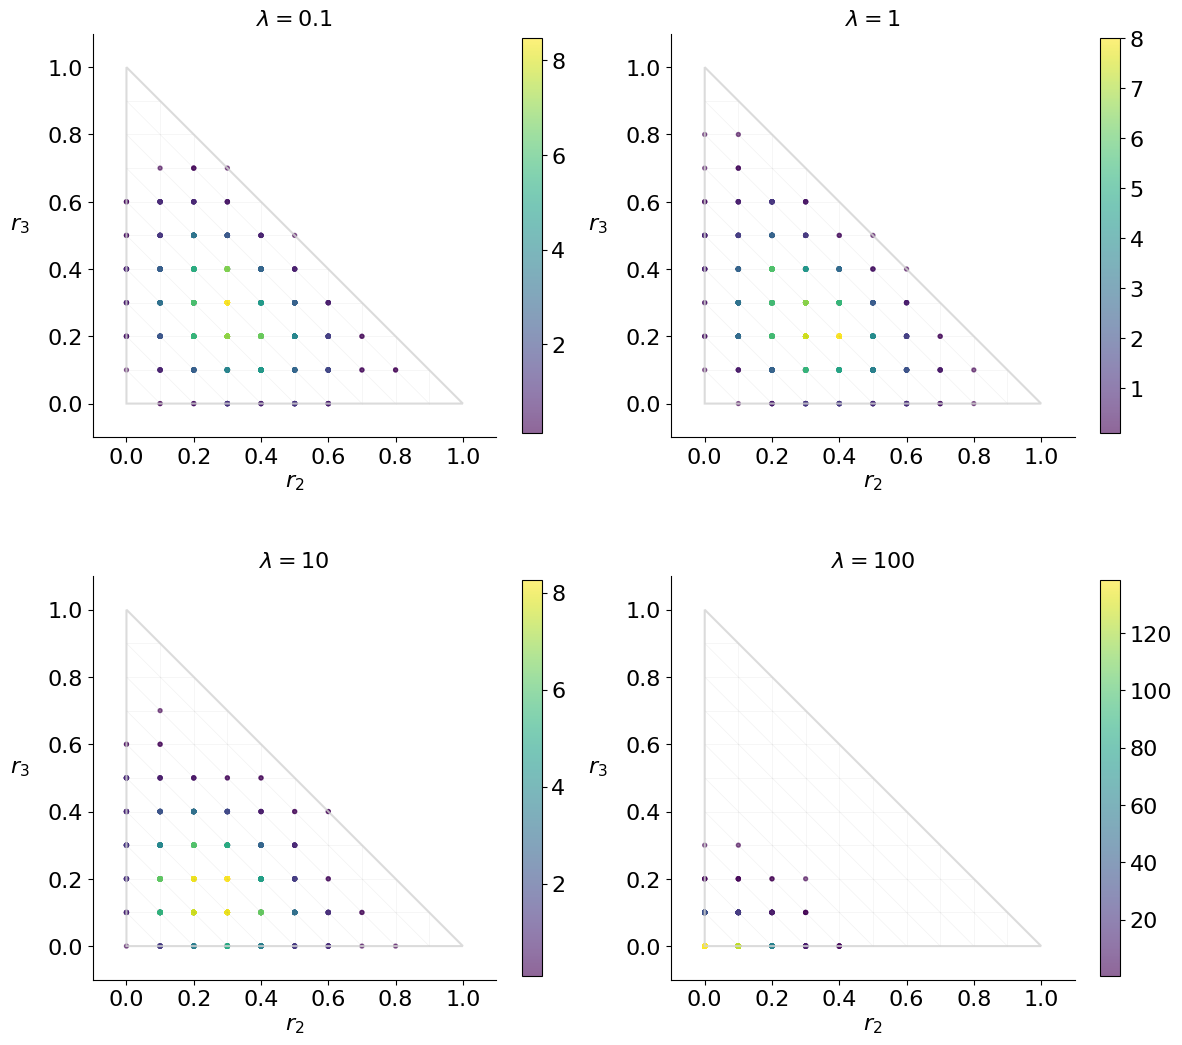

In [16]:
lambdas = [0.1, 1, 10, 100]
alpha_base = [plurality_scores[1] / num_voters, plurality_scores[2] / num_voters , plurality_scores[3] / num_voters]
pl_scores = plurality_scores 
num_samples = 10

np.random.seed(42)
# Create figure with 2x3 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 11))
#fig.suptitle('Dirichlet Distribution Samples with Different λ Values', fontsize=18, y=0.98)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, (lam, ax) in enumerate(zip(lambdas, axes_flat)):

    # Sample from the Dirichlet distribution
    samples = get_sample_prs(pl_scores, lam, num_voters, 10)
    print(samples)
    title = f'$\\lambda = {lam}$'
    plot_marshak_machina_density_for_prob(samples, method='scatter_density', 
                                title=title,
                                cmap='viridis', alpha=0.6, s=8, ax=ax)
    
    # Print summary statistics
    mean_probs = np.mean(samples, axis=0)
    std_probs = np.std(samples, axis=0)
    print(f"\nλ = {lam}:")
    print(f"  Mean probabilities: [{mean_probs[0]:.3f}, {mean_probs[1]:.3f}, {mean_probs[2]:.3f}]")
    print(f"  Std deviations: [{std_probs[0]:.3f}, {std_probs[1]:.3f}, {std_probs[2]:.3f}]")

plt.tight_layout()
plt.savefig("graphs/dirichlet_probs.pdf", bbox_inches="tight")
plt.show()

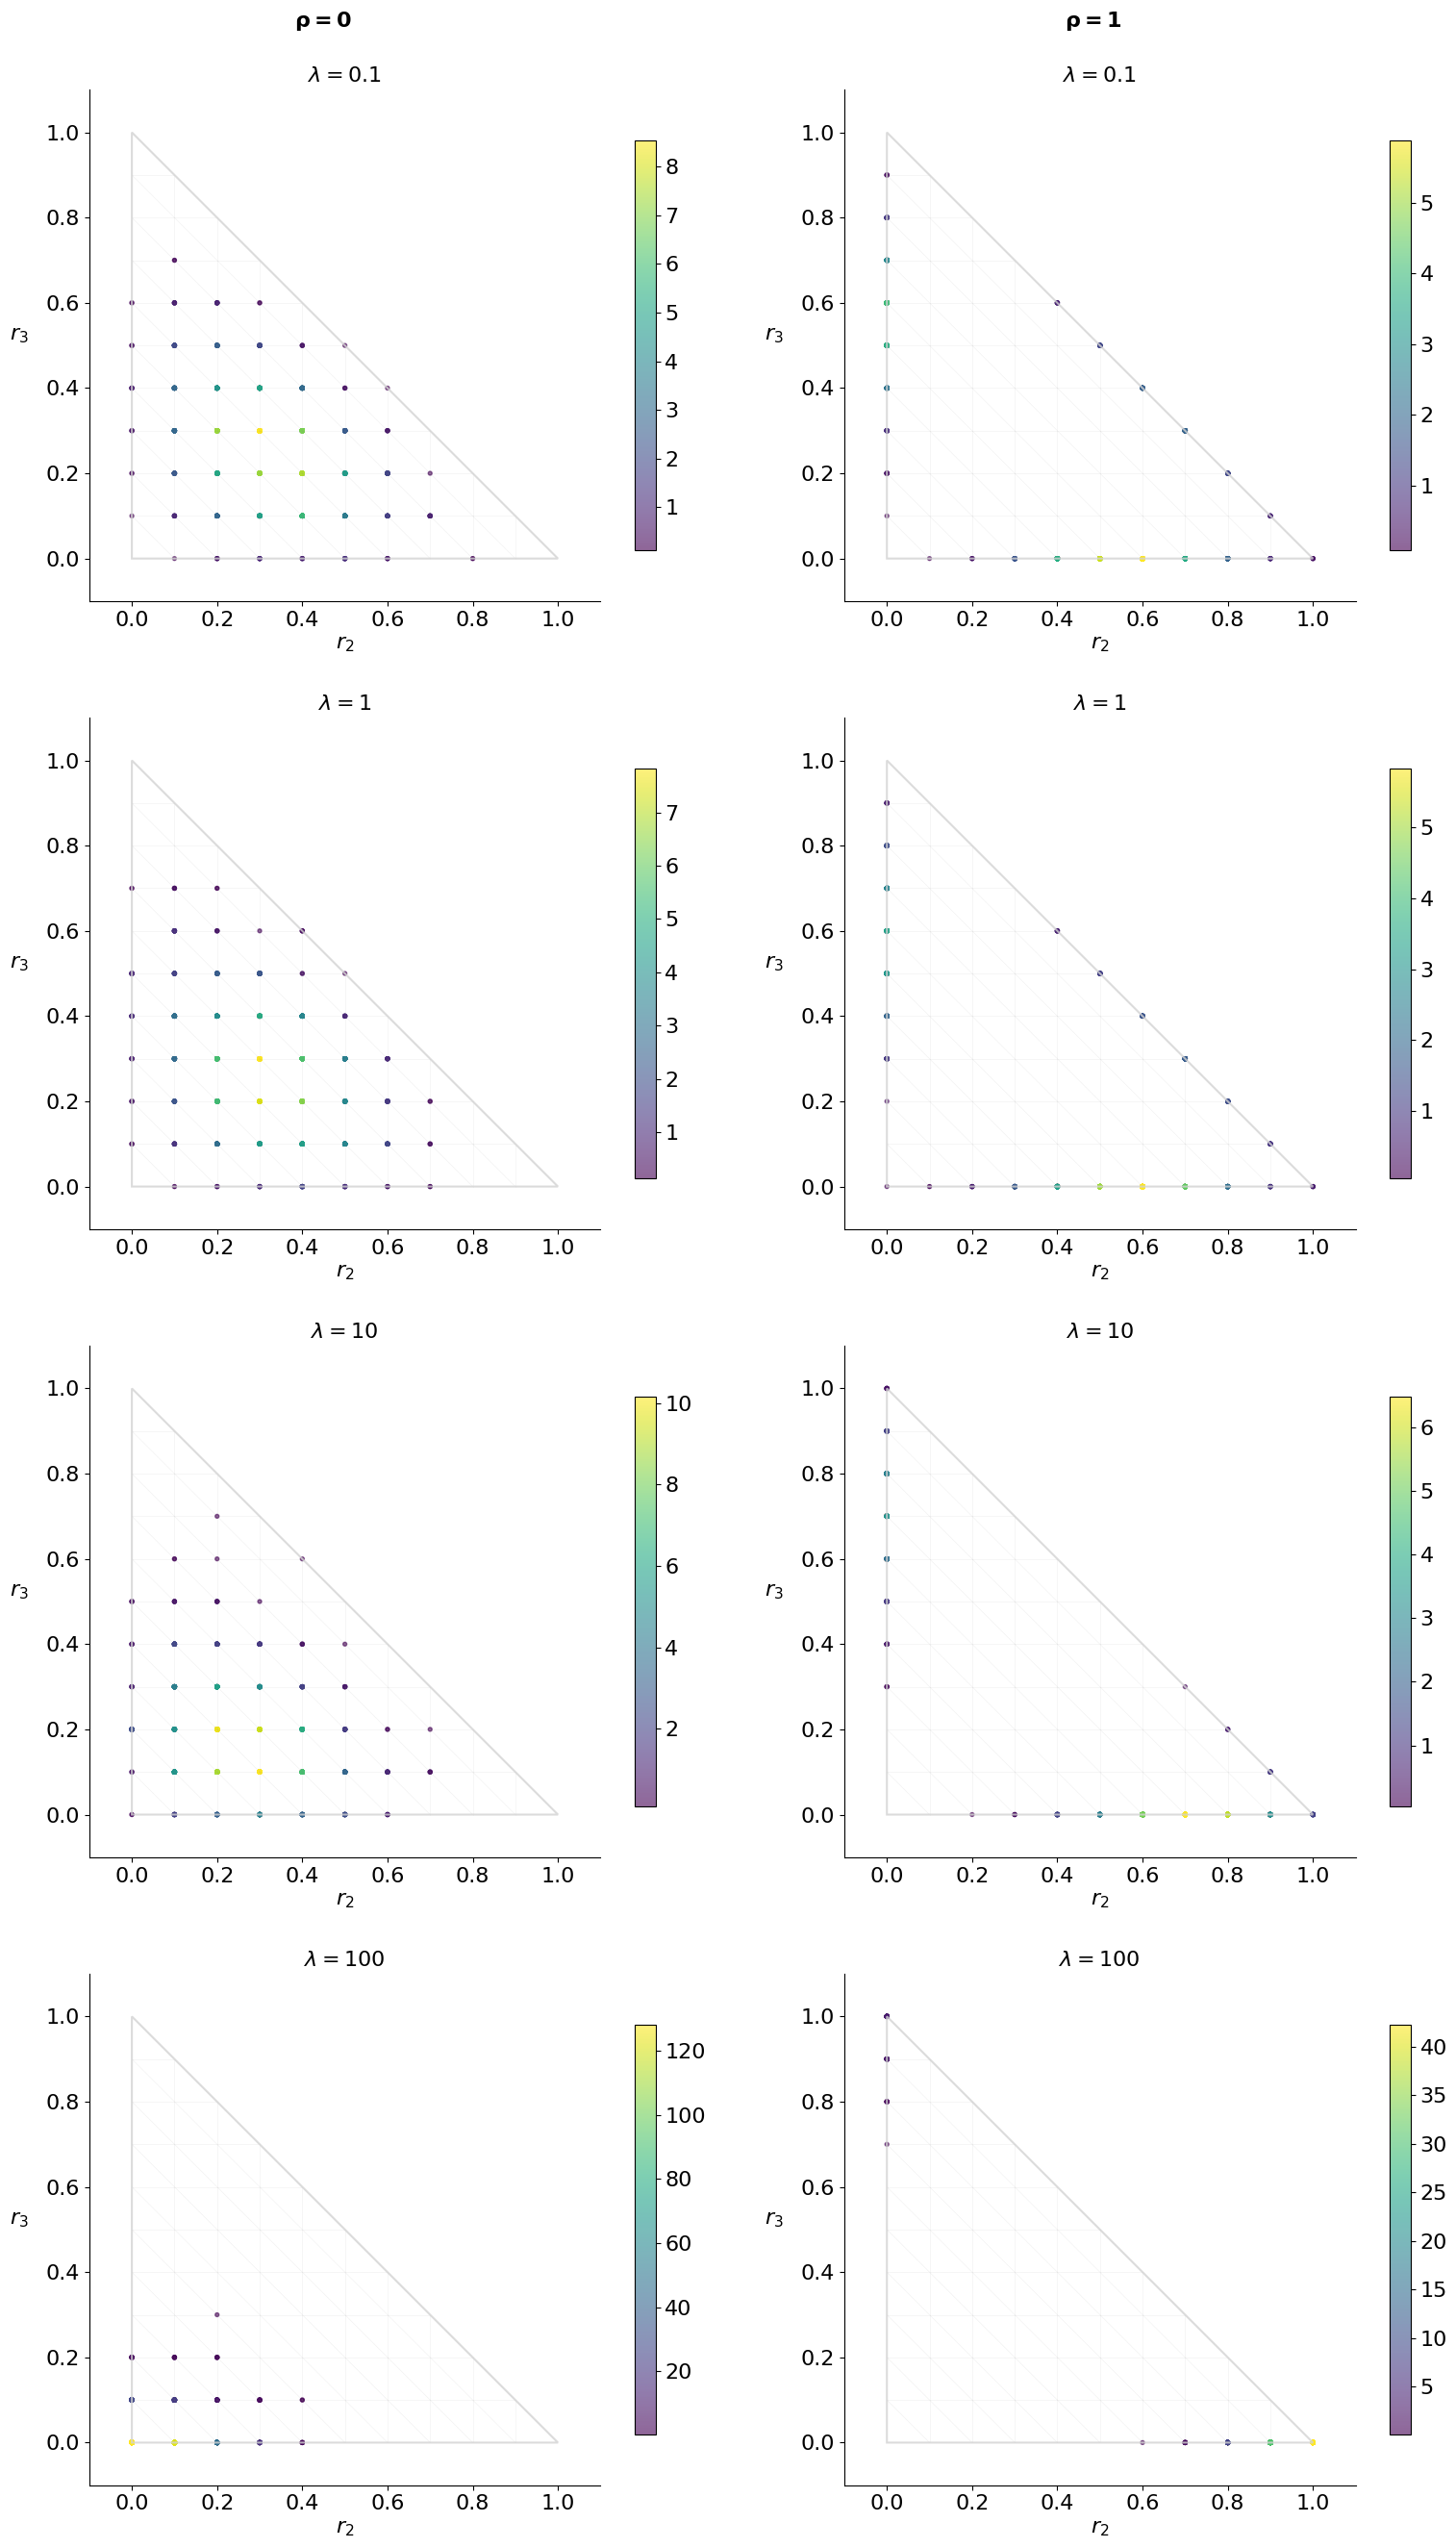

In [ ]:
lambdas = [0.1, 1, 10, 100]
alpha_base = [plurality_scores[1] / num_voters, plurality_scores[2] / num_voters , plurality_scores[3] / num_voters]
pl_scores = plurality_scores 
num_samples = 10

np.random.seed(2)

fig, axes = plt.subplots(4, 2, figsize=(16, 26))

# Add column headers
fig.text(0.23, 1.01, '$\\mathbf{\\rho=0}$', fontsize=16, ha='center', fontweight='bold')
fig.text(0.73, 1.01, '$\\mathbf{\\rho=1}$', fontsize=16, ha='center', )

# Iterate through lambdas
for i, lam in enumerate(lambdas):
    # Get both types of samples
    samples = get_sample_prs(pl_scores, lam, num_voters, 10)
    strategic_samples = get_sample_strategic_prs(pl_scores, lam, num_voters, 10)
    
    # Plot regular samples in left column (column 0)
    ax_left = axes[i, 0]
    title_left = f'$\\lambda = {lam}$'
    plot_marshak_machina_density_for_prob(samples, method='scatter_density', 
                                        title=title_left,
                                        cmap='viridis', alpha=0.6, s=8, ax=ax_left)
    
    # Plot strategic samples in right column (column 1)
    ax_right = axes[i, 1]
    title_right = f'$\\lambda = {lam}$'
    plot_marshak_machina_density_for_prob(strategic_samples, method='scatter_density',title=title_right, cmap='viridis', alpha=0.6, s=8, ax=ax_right)


plt.tight_layout(h_pad=3.0)
plt.savefig("graphs/dirichlet_with_strats.pdf", bbox_inches="tight")
plt.show()